In [4]:
# Copyright (c) 2019-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

In [5]:
#
# Code to generate sentence representations from a pretrained model.
# This can be used to initialize a cross-lingual classifier, for instance.
#

In [6]:
import os
import torch

from src.utils import AttrDict
from src.data.dictionary import Dictionary, BOS_WORD, EOS_WORD, PAD_WORD, UNK_WORD, MASK_WORD
from src.model.transformer import TransformerModel

FAISS library was not found.
FAISS not available. Switching to standard nearest neighbors search implementation.


## Reload a pretrained model

In [7]:
model_path = 'dumped/xlm_mlm_enzh/93kejnkflp/best-valid_en_mlm_ppl.pth'
reloaded = torch.load(model_path)
params = AttrDict(reloaded['params'])
print("Supported languages: %s" % ", ".join(params.lang2id.keys()))

Supported languages: en, zh


## Build dictionary / update parameters / build model

In [8]:
# build dictionary / update parameters
dico = Dictionary(reloaded['dico_id2word'], reloaded['dico_word2id'], reloaded['dico_counts'])
params.n_words = len(dico)
params.bos_index = dico.index(BOS_WORD)
params.eos_index = dico.index(EOS_WORD)
params.pad_index = dico.index(PAD_WORD)
params.unk_index = dico.index(UNK_WORD)
params.mask_index = dico.index(MASK_WORD)
params.label_smoothing = 0

# build model / reload weights
is_encoder = True
with_output = True
model = TransformerModel(params, dico, is_encoder, with_output)
model.eval()
model.load_state_dict(reloaded['model'])

<All keys matched successfully>


## Get sentence representations

Sentences have to be in the BPE format, i.e. tokenized sentences on which you applied fastBPE.

Below you can see an example for English, French, Spanish, German, Arabic and Chinese sentences.

In [9]:
# Below is one way to bpe-ize sentences
codes = "data/processed/XLM_en_zh/50k/codes" # path to the codes of the model
fastbpe = os.path.join(os.getcwd(), 'tools/fastBPE/fast')

def to_bpe(sentences):
    # write sentences to tmp file
    with open('./tmp/sentences', 'w') as fwrite:
        for sent in sentences:
            fwrite.write(sent + '\n')
    
    # apply bpe to tmp file
    os.system('%s applybpe ./tmp/sentences.bpe ./tmp/sentences %s' % (fastbpe, codes))
    
    # load bpe-ized sentences
    sentences_bpe = []
    with open('./tmp/sentences.bpe') as f:
        for line in f:
            sentences_bpe.append(line.rstrip())
    
    return sentences_bpe


In [37]:
# Below are already BPE-ized sentences

# list of (sentences, lang)
raw_sentences = [
#     'think of the internet of things: sci-fi scripts in life',
#     '物联网随想：生活中的科幻剧本',
#     'your cellphone looks great.',
#     '您的手机看起来很棒'
#     'what are the future issues?',
#     '未来的议题是什么？',    
#     'Will it snow tomorrow?',
#     '明天会下雪吗？',
#     'who is in control of your data?',
#     '谁在掌控你的数据'
    'i like my phone',
    'will it snow tomorrow',
    'hurricanes have hit the us',
    'how old are you',
    'what is your age'
]

# bpe-ize sentences
sentences = to_bpe(raw_sentences)
print('\n\n'.join(sentences))

# check how many tokens are OOV
n_w = len([w for w in ' '.join(sentences).split()])
n_oov = len([w for w in ' '.join(sentences).split() if w not in dico.word2id])
print('Number of out-of-vocab words: %s/%s' % (n_oov, n_w))

# add </s> sentence delimiters
sentences = [(('</s> %s </s>' % sent.strip()).split()) for sent in sentences]

your cell@@ phone looks great@@ .

i like my phone

will it snow tomorrow

hurricanes have hit the us

how old are you

what is your age
Number of out-of-vocab words: 0/27


### Create batch

In [38]:
bs = len(sentences)
slen = max([len(sent) for sent in sentences])

word_ids = torch.LongTensor(slen, bs).fill_(params.pad_index)
for i in range(len(sentences)):
    sent = torch.LongTensor([dico.index(w) for w in sentences[i]])
    word_ids[:len(sent), i] = sent

lengths = torch.LongTensor([len(sent) for sent in sentences])
                             
# NOTE: No more language id (removed it in a later version)
# langs = torch.LongTensor([params.lang2id[lang] for _, lang in sentences]).unsqueeze(0).expand(slen, bs) if params.n_langs > 1 else None
# langs = None
langs = torch.LongTensor([0, 0, 0, 0, 0, 0]).unsqueeze(0).expand(slen, bs)

In [39]:
params.lang2id

{'en': 0, 'zh': 1}

### Forward

In [43]:
tensor = model('fwd', x=word_ids, lengths=lengths, langs=langs, causal=False).contiguous()
tensor = tensor.transpose(0, 1).sum(dim=1)
vector = tensor.cpu().detach().numpy()
print(tensor.size())

torch.Size([6, 512])


The variable `tensor` is of shape `(sequence_length, batch_size, model_dimension)`.

`tensor[0]` is a tensor of shape `(batch_size, model_dimension)` that corresponds to the first hidden state of the last layer of each sentence.

This is this vector that we use to finetune on the GLUE and XNLI tasks.

In [46]:
import numpy as np

from scipy import spatial
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

def cosine_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)
    # return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    
def heatmap(vectors):
    
    values = []
    for v1 in vectors:
        values.append([cosine_similarity(v1, v2) for v2 in vectors])
    values = np.array(values)   
        
    fig, ax = plt.subplots()
    im = ax.imshow(values)
    
    ax.set_xticks(np.arange(len(raw_sentences)))
    ax.set_yticks(np.arange(len(raw_sentences)))

    ax.set_xticklabels(raw_sentences)
    ax.set_yticklabels(raw_sentences)
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    
    for i in range(len(raw_sentences)):
        for j in range(len(raw_sentences)):
            text = ax.text(j, i, float("{:.1f}".format(values[i, j])), ha="center", va="center", color="w")

    ax.set_title("...")
    fig.tight_layout()
    plt.show()


# def wordlevel_heatmap(vectors):
        
#     values = []
#     for v1 in vectors[0]:
#         values.append([cosine_similarity(v1, v2) for v2 in vectors[1]])
#     values = np.array(values)   
        
#     fig, ax = plt.subplots()
#     im = ax.imshow(values)
    
#     sentences[0] = sentences[0] + ['<pad>']
#     ax.set_xticks(np.arange(len(sentences[0])))
#     ax.set_yticks(np.arange(len(sentences[1])))

#     ax.set_xticklabels(sentences[0])
#     ax.set_yticklabels(sentences[1])
    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    
#     for i in range(len(raw_sentences[0])):
#         for j in range(len(raw_sentences[1])):
#             text = ax.text(j, i, float("{:.2f}".format(values[i, j])), ha="center", va="center", color="w")

#     ax.set_title("...")
#     fig.tight_layout()
#     plt.show()

        
    
        

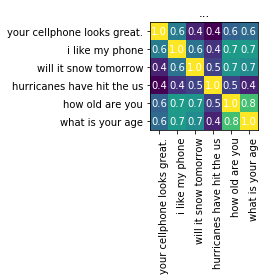

In [47]:
heatmap(vector)

In [36]:
# wordlevel_heatmap(vector)

In [170]:
cosine_similarity(vector[0], vector[1])

0.3317045569419861

In [171]:
cosine_similarity(vector[2], vector[3])

0.47779563069343567

In [172]:
cosine_similarity(vector[4], vector[5])

0.5645474791526794

In [173]:
cosine_similarity(vector[6], vector[7])

0.6147135496139526

In [174]:
cosine_similarity(vector[8], vector[9])

0.5283835530281067

In [161]:
cosine_similarity(vector[0], vector[1])

0.3110550045967102

In [162]:
cosine_similarity(vector[2], vector[3])

0.4230247437953949

In [163]:
cosine_similarity(vector[4], vector[5])

0.4671783149242401

In [164]:
cosine_similarity(vector[6], vector[7])

0.48970329761505127

In [165]:
cosine_similarity(vector[8], vector[9])

0.4246571958065033